<a href="https://colab.research.google.com/github/tschelli/Stroke_Prediction_Project/blob/main/Stroke_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stroke Prediction 

Coding Dojo Data Science Project 2

- Name: Tyler Schelling
- Date Started: 11/2/2022

- Last Updated: 11/8/2022

---

##Dataset Source


Dataset can be found on Kaggle: [Stroke Prediction Dataset]https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

##Data Dictionary


Column Name | Description
---|---
id | Unique identifier
gender| 'Male', 'Female', or 'Other'
age| Age of the patient
hypertension | 0 if patient doesn't have hypertension, 1 if the patient has hypertension
ever_married | 'No' or 'Yes'
work_type | 'children', 'govt_job', 'never_worked', 'private', or 'self-employed'
Residence_type | 'Rural' or 'Urban'
avg_glucose_level | average glucose level in blood
bmi | body mass index
smoking_status | 'formerly smoke', 'never smoked', 'smokes', or 'unknown'
stroke | 1 if the patient had a stroke or 0 if not

##Mount Drive | Import Libraries | Download Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [3]:
#Download the data and display the head of the dataframe
filename = '/content/drive/MyDrive/02. Life/Coding Dojo/00 Datasets/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(filename)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
#Evaluate size of the dataframe
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset contains 5110 rows and 12 columns.


##Explore and Clean the Dataset

###Copy DF for Exploratory Analysis and Machine Learning

In [5]:
#Create df copies in order to keep original data (df) intact
eda_df = df.copy()
ml_df = df.copy()

---

###Check for Unnecessary Columns

- The `id` column provides no value for predictive modeling. It can be dropped.

In [6]:
#Dropping the id column from both df's
eda_df.drop(columns = 'id', inplace = True)
ml_df.drop(columns = 'id', inplace = True)

- `id` has been dropped from both dataframes as it provides no value in exploratory analysis or machine learning. 

---

###Check for Duplicates

In [7]:
#Evalutate if duplicates are present in the dataframe
eda_df.duplicated().sum()

0

- No duplicated rows

---

###Identify Missing Values

In [8]:
#Iterates through columns with missing values to determine the total quantity and percent missing from the column.
col_with_nan = [features for features in eda_df.columns if eda_df[features].isnull().sum()>=1]
total_nan = []
for col in col_with_nan:
    total_nan.append(eda_df[col].isnull().sum())
percent_nan = []
for col in col_with_nan:
    percent_nan.append(np.round(eda_df[col].isnull().mean(),5))

print(f'The column(s) {col_with_nan} have {total_nan} missing values accounting for {percent_nan} % of the columns missing values respectively. ')

The column(s) ['bmi'] have [201] missing values accounting for [0.03933] % of the columns missing values respectively. 


- The `bmi` column has 201 missing values (0.03933% missing values). 

###Address Missing Values

Missing values will only be addressed for exploratory data analysis (eda_df) at this time. Machine learning missing values will be imputed at a later time to prevent data leakage.

In [9]:
#Fill missing BMI values in with the median value based on the gender for EDA purposes. 
#Machine learning will be imputed at a later time to avoid data leakage.
eda_df['bmi'] = eda_df['bmi'].fillna(eda_df.groupby('gender')['bmi'].transform('median'))

print(eda_df['bmi'].isnull().sum())

0


- All missing values in `eda_df` have been addressed.

---

###Identify Inconsistencies in Categorical Values

In [10]:
#Iterate through categorical columns to print values to determine if inconsistencies are present.
cat_cols = [columns for columns in eda_df.columns if eda_df[columns].dtype=='object']

for col in cat_cols:
    print(f'{col}:')
    print(eda_df[col].value_counts())
    print('\n')

gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


ever_married:
Yes    3353
No     1757
Name: ever_married, dtype: int64


work_type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Residence_type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


smoking_status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64




- No major inconsistencies present in categorical data
- Only 1 data point for `gender` being 'Other' may be of concern, but will remain untouched.

In [11]:
#Verify the age values in work_type = children are valid.
age_filter = eda_df['work_type'] == 'children'
eda_df[age_filter]['age'].max()

16.0

- Verified the age of `work_type` = `children` is valid.

###EDA Visuals

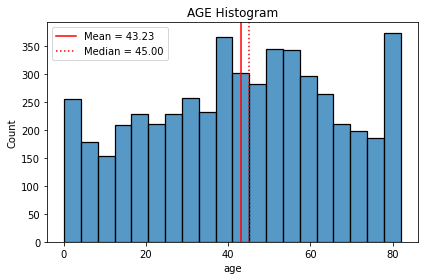

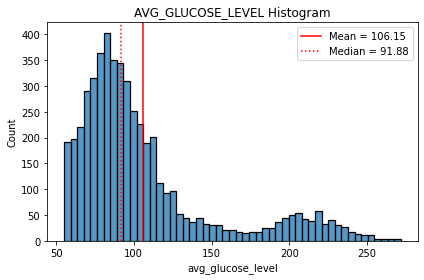

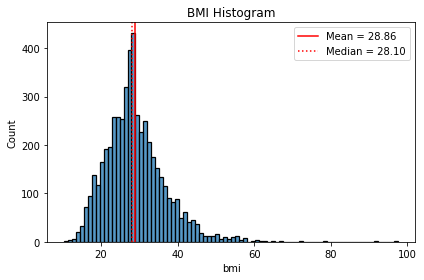

In [12]:
#Histograms for continuous values
continuous_cols = ['age', 'avg_glucose_level', 'bmi']

for cols in continuous_cols:
    mean = eda_df[cols].mean()
    median = eda_df[cols].median()
    fig, ax = plt.subplots(nrows=1, facecolor='w')
    sns.histplot(data = eda_df[cols], linewidth = 1.25, bins = 'auto')
    ax.axvline(mean, color = 'red', linewidth = 1.5, label = f'Mean = {mean:,.2f}')
    ax.axvline(median, color = 'red', ls = 'dotted', linewidth = 1.5, label = f'Median = {median:,.2f}')
    plt.title(f'{cols.upper()} Histogram')
    ax.legend()
    plt.tight_layout()
    plt.show();

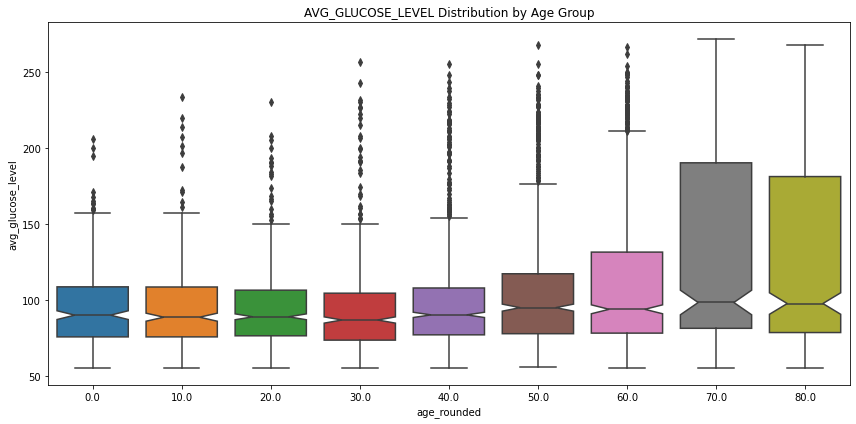

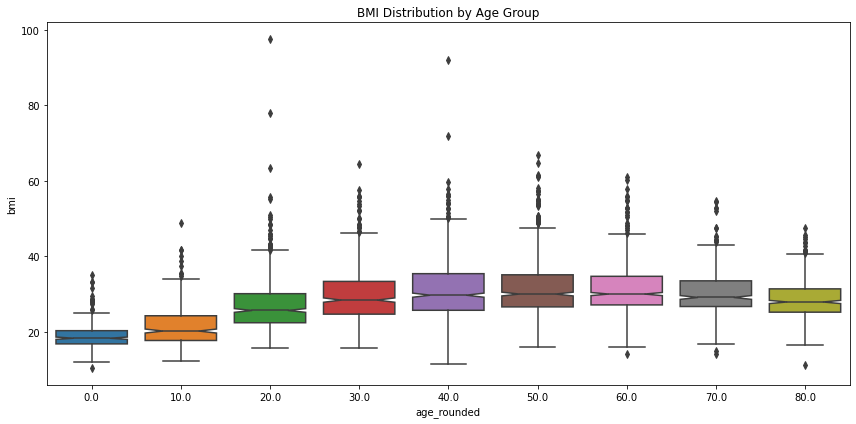

In [13]:
#Create a new column to group the ages rounded to the nearest tenth
eda_df['age_rounded'] = eda_df['age'].round(-1)

#Boxplots to show distribution of data in two continuous columns with potential for outliers.
outlier_cols = ['avg_glucose_level', 'bmi']

for cols in outlier_cols:
    fig, ax = plt.subplots(nrows=1, facecolor='w', figsize = (12,6))
    sns.boxplot(data = eda_df, x=eda_df['age_rounded'], y = eda_df[cols], notch = True)
    plt.title(f'{cols.upper()} Distribution by Age Group')
    plt.tight_layout()
    plt.show();  

###Evaluate Outliers

Outliers in `avg_glucose_level` are high, but are not completely unreasonable. Values will remain untouched.

Outliers in `bmi` that are greater than 70 seem unrealistic and will require further evaluation.

In [14]:
#Create a BMI filter and apply to the df
bmi_filter = eda_df['bmi'] > 70

eda_df[bmi_filter]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_rounded
544,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0,40.0
928,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0,20.0
2128,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0,20.0
4209,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0,40.0


- Row 544 will remain due to the high `avg_glucose_level` in conjunction with their high `bmi`.
- The other 3 rows will be dropped. 
    - Greater than 78 `bmi` levels with relatively normal `avg_glucose_level`'s would be incredibly unlikely. (https://ccforum.biomedcentral.com/articles/10.1186/s13054-021-03795-z)
    - Only removing 0.00059% of the data from the dataset.

In [15]:
#Drop the index values of the associated rows that were deemed to have too high of a BMI.
eda_df.drop([928, 2128, 4209], axis= 0, inplace=True)
ml_df.drop([928, 2128, 4209], axis= 0, inplace=True)

#Verify high BMI's were removed.
display(eda_df[bmi_filter])
print('\n')
display(ml_df[ml_df['bmi'] > 70])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_rounded
544,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0,40.0


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
544,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0


- Outliers in continuous data dropped

##Exploratory Data Analysis

###Functions for Plot Creation

In [137]:
def hist_box_plot(column_name, x_Label, bin_count):
    sns.set(style="white")

    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10, 6))
    plt.suptitle(f'{column_name.capitalize()} Distribution', y=1.02, va='center', fontsize = 19, weight='bold')

    sns.boxplot(data = eda_df, x = column_name, ax=ax_box, color = '#14e01b')
    ax_box.spines['top'].set_color(None)
    ax_box.spines['bottom'].set_color(None)
    ax_box.spines['left'].set_color(None)
    ax_box.spines['right'].set_color(None)

    sns.histplot(data = eda_df, x = column_name, ax=ax_hist, color = '#14e01b', bins = bin_count, edgecolor="black")
    plt.xlabel(x_Label, fontsize = 16, weight='bold')
    plt.xticks(weight='bold')
    ax_hist.set_ylabel('Count',fontweight='bold',fontsize=18)
    ax_hist.tick_params(labelcolor='k', labelsize=10)
    ax_hist.set_yticklabels(ax_hist.get_yticks(), weight='bold')
    
    ax_box.set(xlabel='') 
    plt.tight_layout();
    plt.show();

In [181]:
def scatter_plot(x, y):
    palette_dict = {1: 'red', 0: 'green'}
    fig, ax = plt.subplots(figsize=(8,6), facecolor='w')
    sns.scatterplot(hue_order=[0,1], data=eda_df.sort_values('stroke'), x=x, y=y, hue="stroke", palette=palette_dict);
    plt.title(f'{x.capitalize()} and {y.capitalize()} \ncorrelation to Stroke Outcome', fontsize = 18, weight='bold')
    plt.xlabel(f'{x}', fontsize = 14, weight='bold')
    plt.ylabel(f'{y}', fontsize = 14, weight='bold');
    plt.xticks(fontsize = 10, weight='bold')
    plt.yticks(fontsize = 10, weight='bold');
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.show;

###Correlation to Target

In [27]:
#Create a features dataframe to encode categorical data for correlation
feat_df = eda_df.copy()
feat_df.drop(columns = 'age_rounded', inplace = True)
objList = feat_df.select_dtypes(include = "object").columns
feat_df[objList] = feat_df[objList].apply(LabelEncoder().fit_transform)

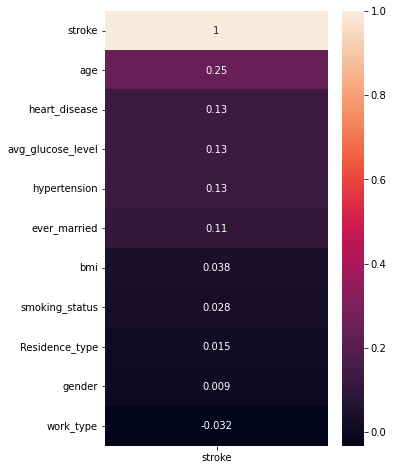

In [28]:
#Sort the correlations of each column to SalePrice
corr = feat_df.corr()[['stroke']].sort_values(by = 'stroke', ascending = False)
plt.figure(figsize= (5,8))
sns.heatmap(corr, annot = True);

- No features particularly stick out for correlation to the target variable. 
- Age, heart_disease, avg_glucose_level, and hypertension have the largest correlation to a patient having a stroke.
- Ever_married strangely has a similar degree of correlation as the medical related columns. 

###Univariate Analysis

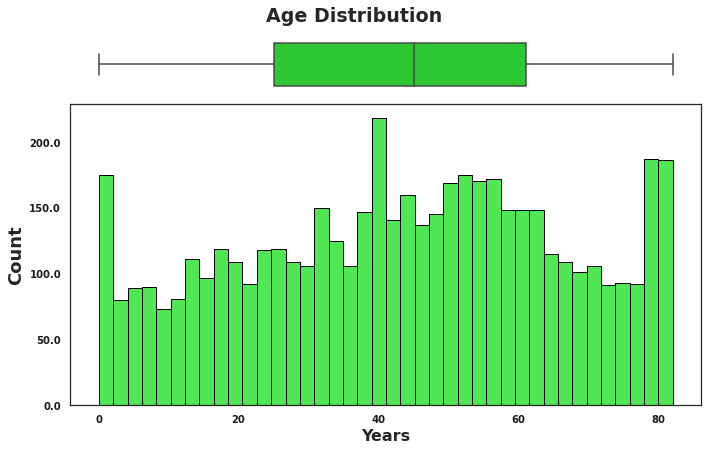

In [138]:
hist_box_plot('age', 'Years', 40)

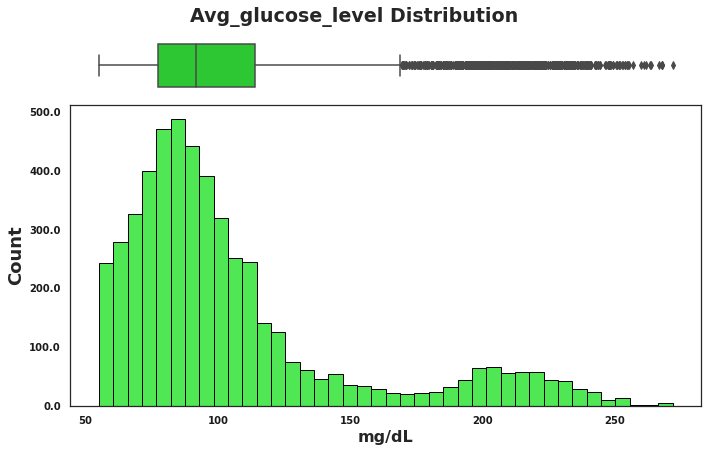

In [141]:
hist_box_plot('avg_glucose_level', 'mg/dL', 40)

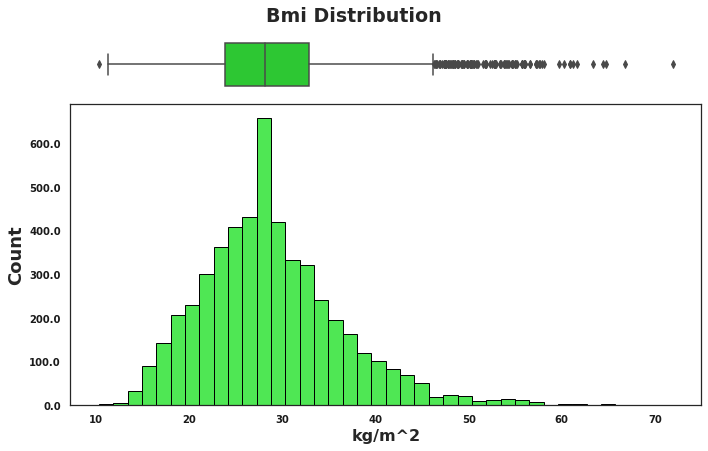

In [142]:
hist_box_plot('bmi', 'kg/m^2', 40)

- NEED ANALYSIS

###Multivariate Analysis

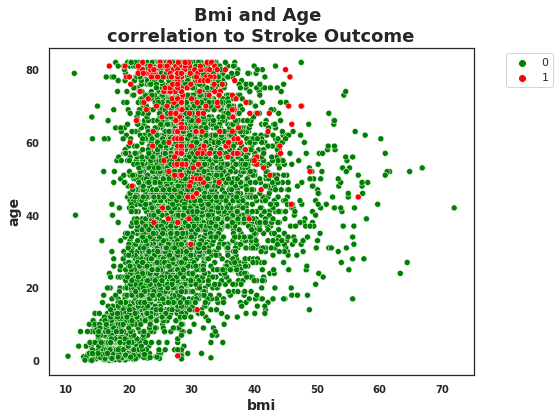

In [182]:
scatter_plot('bmi', 'age')

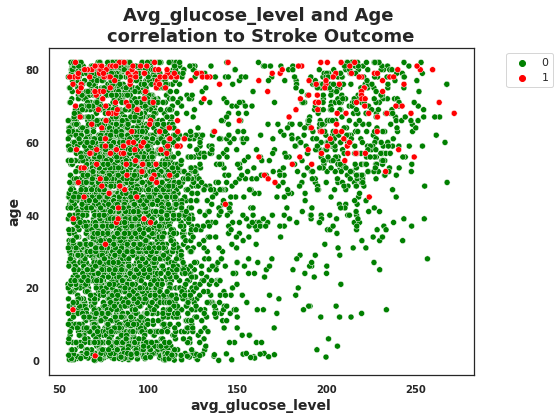

In [183]:
scatter_plot('avg_glucose_level', 'age')

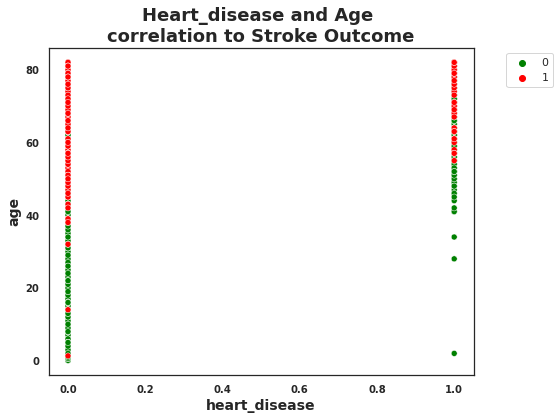

In [185]:
scatter_plot('heart_disease', 'age')

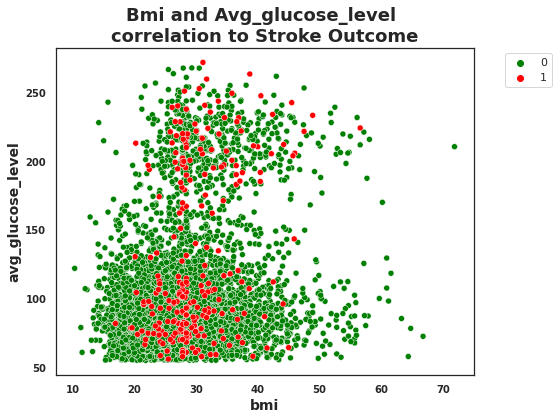

In [184]:
scatter_plot('bmi', 'avg_glucose_level')